In [23]:
import torch
import numpy as np

In [1]:
x = torch.ones(2,2)

NameError: name 'torch' is not defined

In [ ]:
print(x)
print(x.dtype)

In [ ]:
x = torch.ones(2,2, dtype = torch.int8)
print(x)
print(x.dtype)

In [ ]:
print(x.dtype)
x = x.type(torch.float)
print(x.dtype)

In [ ]:
print(x.dtype)
y = x.numpy()
print(y.dtype)
print(y)

In [ ]:
y

In [ ]:
z = torch.from_numpy(y)
print(z)
print(z.dtype)

In [2]:
from torchvision import datasets
path2data = "./data"
train_data = datasets.MNIST(path2data, train = True, download = True)

In [3]:
x_train, y_train = train_data.data, train_data.targets
print(x_train.shape)
print(y_train.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [4]:
val_data = datasets.MNIST(path2data, train = False, download = True)
x_val,y_val = val_data.data , val_data.targets
print(x_val.shape)
print(y_val.shape)

torch.Size([10000, 28, 28])
torch.Size([10000])


In [5]:
if len(x_train.shape) == 3:
    x_train = x_train.unsqueeze(1)
print(x_train.shape)

if len(x_val.shape) == 3:
    x_val = x_val.unsqueeze(1)
print(x_val.shape)



torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


In [6]:
from torchvision import utils
import matplotlib.pyplot as plt

In [7]:
def show(img):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr, interpolation='nearest')

In [8]:
x_grid = utils.make_grid(x_train[:40], nrow= 8 , padding= 2)
show(x_grid)

NameError: name 'np' is not defined

In [9]:
from torchvision import transforms

In [13]:
data_transform = transforms.Compose([
    transforms.RandomRotation((-30,30)),
#     transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor()
])



In [14]:
img = train_data[0][0]
img_tr = data_transform(img)

img_tr = img_tr.numpy()

Text(0.5, 1.0, 'transformed')

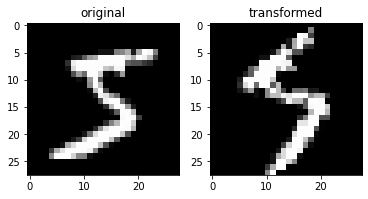

In [15]:
plt.subplot(1,2,1)
plt.imshow(img,cmap = 'gray')
plt.title("original")
plt.subplot(1,2,2)
plt.imshow(img_tr[0], cmap = "gray")
plt.title("transformed")

In [16]:
train_data = datasets.MNIST(path2data, train = True, download = False, transform = data_transform)

In [17]:
x_train, y_train = train_data.data, train_data.targets
if len(x_train.shape) == 3:
    x_train = x_train.unsqueeze(1)
print(x_train.shape)

if len(x_val.shape) == 3:
    x_val = x_val.unsqueeze(1)
print(x_val.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


In [18]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)


In [19]:
for x,y in train_ds:
    print(x.shape, y.item())
    break

torch.Size([1, 28, 28]) 5


In [20]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size = 8)
val_dl = DataLoader(val_ds, batch_size = 8)

for xb,yb in train_dl:
    print(xb.shape)
    print(yb.shape)
    break

torch.Size([8, 1, 28, 28])
torch.Size([8])


In [21]:
from torch import nn

model = nn.Sequential(
    nn.Linear(4,5),
    nn.ReLU(),
    nn.Linear(5,1),

)
print(model)

Sequential(
  (0): Linear(in_features=4, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
)


In [129]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,20,5,1)
        self.conv2 = nn.Conv2d(20,50,5,1)
        self.fc1 = nn.Linear(4*4*50,500)
        self.fc2 = nn.Linear(500,10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [130]:
model = Net()
model = model.to(device)

In [131]:
print(model)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [132]:
loss_func = nn.NLLLoss(reduction= "sum")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [133]:
for xb,yb in train_dl:
    xb = xb.type(torch.float).to(device)
    yb = yb.to(device)
    
    out = model(xb)
    loss = loss_func(out,yb)
    print(loss.item())
    break

97.57041931152344


In [80]:
loss.backward()

In [134]:
from torch import optim
opt = optim.Adam(model.parameters(), lr = 1e-4)

In [82]:
opt.step()
opt.zero_grad()

In [135]:
def loss_batch(loss_func, xb, yb, yb_h, opt = None):
    loss = loss_func(yb_h, yb)
    metric_b = metric_batch(yb,yb_h)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), metric_b

In [136]:
def metric_batch(target, output):
    pred = output.argmax(dim =1, keepdim = True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [137]:
def loss_epoch(model, loss_func, dataset_dl, opt = None):
    loss = 0.0
    metric = 0.0
    len_data = len(dataset_dl.dataset)
    for xb,yb in dataset_dl:
        xb = xb.type(torch.float).to(device)
        yb = yb.to(device)
        yb_h = model(xb)
        
        loss_b, metric_b = loss_batch(loss_func, xb, yb, yb_h, opt)
        
        loss += loss_b
        if metric_b is not None:
            metric += metric_b
   
    loss /=len_data
    metric /=len_data
    
    return loss, metric
        
        

In [138]:
def train_val(epochs, model, loss_func, opt, train_dl, val_dl):
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func = loss_func, dataset_dl = train_dl, opt = opt)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func = loss_func, dataset_dl = val_dl)
            
        accuracy = val_metric*100
        
        print(f"Epoch:{epoch+1} , train_loss: {train_loss}, val_loss: {val_loss}, train_accuracy: {train_metric*100}, val_accuracy: {accuracy}")
        
    return None

In [139]:
num_epochs = 5
train_val(num_epochs, model.cuda(), loss_func, opt, train_dl, val_dl)

Epoch:1 , train_loss: 0.14814061816236881, val_loss: 0.10432322685370164, train_accuracy: 95.8, val_accuracy: 96.44
Epoch:2 , train_loss: 0.04696866674844446, val_loss: 0.05179334586981563, train_accuracy: 98.565, val_accuracy: 98.52
Epoch:3 , train_loss: 0.026723440521855303, val_loss: 0.04774997621272404, train_accuracy: 99.175, val_accuracy: 98.67
Epoch:4 , train_loss: 0.018559664947776458, val_loss: 0.06156008197265955, train_accuracy: 99.43833333333333, val_accuracy: 98.46000000000001
Epoch:5 , train_loss: 0.013763859619872547, val_loss: 0.09979262275360448, train_accuracy: 99.56, val_accuracy: 98.07000000000001
